In [54]:
import pandas as pd
from hkfold import HKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from keras.layers import PReLU
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from keras.models import load_model

In [2]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df.dropna()

In [21]:
features = [
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain',
    'temp', 'soil_temp', 'z', 'air_dens', 'virtual_temp',
    'wind',
    #'H', 'LE',
    #'zL', 'lval',
    #'ustar', 
]

target = 'phi_m'

test_ds = np.random.choice(df.ds.unique(), 12, replace=False)
test_mask = df.ds.isin(test_ds)
train_x, train_y = df[~test_mask][features], df[~test_mask][target]
test_x, test_y = df[test_mask][features], df[test_mask][target]
train_x, train_y = shuffle(train_x, train_y)

print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 1646616, testing with 126840


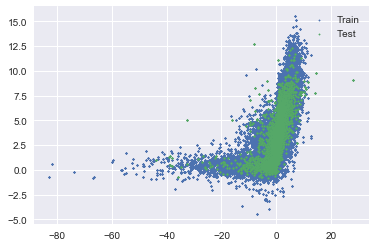

In [14]:
plt.scatter(df[~df.ds.isin(test_ds)].zL, df[~df.ds.isin(test_ds)].phi_m, s=2, label='Train')
plt.scatter(df[df.ds.isin(test_ds)].zL, df[df.ds.isin(test_ds)].phi_m, s=2, label='Test')
plt.legend()
plt.show()

In [22]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

train_x = (train_x - mean_x) /  std_x
test_x = (test_x - mean_x) / std_x

train_y = (train_y - mean_y) / std_y
test_y = (test_y - mean_y) / std_y

In [35]:
model = Sequential([
    Dense(1024, input_shape=(len(features),)), PReLU(),
    Dense(256), PReLU(),
    Dense(128), PReLU(),
    Dense(32), PReLU(),
    Dense(1)
])

opt = RMSprop(lr=0.001)
model.compile(loss='mse', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 1024)              12288     
_________________________________________________________________
p_re_lu_44 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dense_56 (Dense)             (None, 256)               262400    
_________________________________________________________________
p_re_lu_45 (PReLU)           (None, 256)               256       
_________________________________________________________________
dense_57 (Dense)             (None, 128)               32896     
_________________________________________________________________
p_re_lu_46 (PReLU)           (None, 128)               128       
_________________________________________________________________
dense_58 (Dense)             (None, 32)                4128      
__________

In [36]:
hist = model.fit(
    train_x, train_y,
    batch_size=2048, epochs=20,
    shuffle=True,
    callbacks=[
        ReduceLROnPlateau(factor=0.2, verbose=1, min_lr=1e-6),
        ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                        verbose=1, save_best_only=True),
        TensorBoard('dev/logs/', write_graph=False, write_grads=True),
        EarlyStopping(min_delta=0.0001, patience=50),
    ],
    validation_data=(test_x, test_y)
)

Train on 1646616 samples, validate on 126840 samples
Epoch 1/20
1640448/1646616 [============================>.] - ETA: 0s - loss: 0.2766
Epoch 00001: val_loss improved from inf to 0.29332, saving model to dev/models/weights-w.0001-0.2933.hdf5
1646616/1646616 [==============================] - 14s 8us/step - loss: 0.2762 - val_loss: 0.2933
Epoch 2/20
1646592/1646616 [============================>.] - ETA: 0s - loss: 0.1677
Epoch 00002: val_loss improved from 0.29332 to 0.18185, saving model to dev/models/weights-w.0002-0.1818.hdf5
1646616/1646616 [==============================] - 13s 8us/step - loss: 0.1677 - val_loss: 0.1818
Epoch 3/20
1646592/1646616 [============================>.] - ETA: 0s - loss: 0.1488
Epoch 00003: val_loss improved from 0.18185 to 0.18038, saving model to dev/models/weights-w.0003-0.1804.hdf5
1646616/1646616 [==============================] - 13s 8us/step - loss: 0.1488 - val_loss: 0.1804
Epoch 4/20
1646592/1646616 [============================>.] - ETA: 0s - 

In [41]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

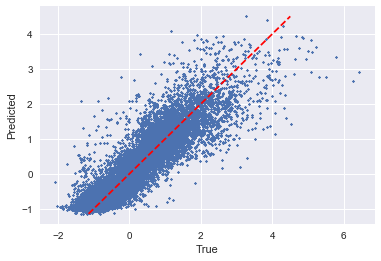

Explained variance 0.8179076602776014
Mean absolute error 0.2673959231562781
Mean squared error 0.15838770579028716
Median absolute error 0.18001211806723388
R2 score 0.8159394986172934
Mean absolute percent error 121.86270892462946


In [55]:
best_model = load_model('dev/models/weights-w.0007-0.1584.hdf5')
y_pred = best_model.predict(test_x)
plot_preds(y_pred, test_y)

from sklearn import metrics
print('Explained variance', metrics.explained_variance_score(test_y, y_pred))
print('Mean absolute error', metrics.mean_absolute_error(test_y, y_pred))
print('Mean squared error', metrics.mean_squared_error(test_y, y_pred))
print('Median absolute error', metrics.median_absolute_error(test_y, y_pred))
print('R2 score', metrics.r2_score(test_y, y_pred))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_y, y_pred)) / test_y.shape
print('Mean absolute percent error', mape[0])